<a href="https://colab.research.google.com/github/acram002/AI-Driven-Recipe-Suggestion-System/blob/main/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Driven Recipe Generation: Data Exploration, Cleaning, and Preprocessing

## Introduction

The goal of this project is to utilize the "deepseek-ai/deepseek-llm-7b-chat" transformer model for AI-driven recipe generation. To ensure high-quality data input, comprehensive data exploration, cleaning, and preprocessing steps must be completed. This document provides a step-by-step explanation of each task, ensuring that the dataset is well-prepared for training the transformer model.




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/full_dataset.csv"
df = pd.read_csv(file_path)  # Load dataset
df.head()  # Display first few rows

Mounted at /content/drive


,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


### **1. Data Exploration and Cleaning**
This step helps understand the dataset structure, identify missing values, and remove redundant data. Exploratory Data Analysis (EDA) reveals potential issues and prepares the data for preprocessing.

#### **1.1 Basic Information & Summary**

In [2]:
# Check dataset structure
print(df.info())
print(df.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB
None
          Unnamed: 0              title  \
count   2.231142e+06            2231141   
unique           NaN            1312870   
top              NaN  Chicken Casserole   
freq             NaN               4099   
mean    1.115570e+06                NaN   
std     6.440754e+05                NaN   
min     0.000000e+00                NaN   
25%     5.577852e+05                NaN   
50%     1.115570e+06                NaN   
75%     1.673356e+06                NaN   
max     2.231141e+06                NaN   

                                          ingredients  \
count                           

### Exploratory Data Analysis (EDA)

EDA helps us understand the dataset, identify inconsistencies, and determine necessary preprocessing steps. The dataset contains 223,114 entries with seven columns:

- Unnamed: 0: Index column (to be removed)

- title: Name of the recipe

- ingredients: List of ingredients used

- directions: Cooking instructions

- link: URL reference

- source: Source of the recipe

- NER: Named Entity Recognition (NER) tags for ingredients and actions


#### **1.2 Handling Missing Values & Duplicates**

In [3]:
print(df.columns)  # List all column names

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')


In [4]:
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Check and remove duplicate entries
print(f"Duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Duplicate rows: 0


In [5]:
# 1.1 Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# 1.2 Fill or remove missing values
# Example: Forward fill any missing entries
df.fillna(method='ffill', inplace=True)

# Alternatively: Drop rows containing missing values
# df.dropna(inplace=True)

Missing values per column:
 title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


<ipython-input-5-d7510137351b>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Handling Missing Values

Missing values can negatively impact model training. We check for null values and apply appropriate techniques:

- If a column has minimal missing values, we remove rows.

- If a column is crucial, we apply imputation techniques such as filling with the most frequent values.

- Dropping irrelevant columns like Unnamed: 0 improves efficiency.

#### **1.3 Feature Analysis**

In [6]:
print(df["source"].value_counts())

source
Gathered     1643098
Recipes1M     588044
Name: count, dtype: int64


We analyze categorical data distributions to identify inconsistencies and potential imbalances.

#### **1.4 Checking Text Lengths**

In [7]:
df["ingredients_length"] = df["ingredients"].apply(lambda x: len(x.split()))
df["directions_length"] = df["directions"].apply(lambda x: len(x.split()))
print(df[['ingredients_length', 'directions_length']].describe())

       ingredients_length  directions_length
count        2.231142e+06       2.231142e+06
mean         4.137092e+01       8.591087e+01
std          2.218255e+01       8.029257e+01
min          1.000000e+00       1.000000e+00
25%          2.600000e+01       3.600000e+01
50%          3.700000e+01       6.100000e+01
75%          5.100000e+01       1.090000e+02
max          1.891000e+03       2.649000e+03


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Example: Normalizing 'ingredients_length' and 'directions_length'
scaler = MinMaxScaler()
df[["ingredients_length", "directions_length"]] = scaler.fit_transform(
    df[["ingredients_length", "directions_length"]]
)

# Now explicitly show part of the DataFrame (e.g., top 5 rows)
df.head()

,title,ingredients,directions,link,source,NER,ingredients_length,directions_length
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",0.015873,0.022281
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",0.010582,0.010574
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",0.013757,0.010952
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",0.015873,0.023414
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",0.012698,0.012840


### Normalization of Numerical Data

Although most columns are text-based, any numerical attributes should be normalized to ensure model compatibility.

### Identifying and Handling Class Imbalances

Class imbalances can bias the model’s predictions. Using count plots or frequency distributions, we verify if certain recipe types (if present) are overrepresented and apply techniques like oversampling or undersampling.

### Dataset Summary Statistics

We generate key statistical summaries:

- Mean, median, mode for numerical data

- Unique value counts for categorical data

- Outlier detection using interquartile range (IQR)



### **2. Data Preprocessing & Transformation**
This step prepares text data for compatibility with the transformer model.

#### **2.1 Tokenization for Model Compatibility**

In [9]:
!pip install --upgrade tokenizers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 107.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.0
    Uninstalling transformers-4.50.0:
      Successfully uninstalled transformers-4.50.0


In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-llm-7b-chat")

df_sample = df.sample(n=1000, random_state=42)  # Take 1,000 random rows
ingredients_list = df_sample["ingredients"].astype(str).tolist()

tokenized_sample = tokenizer(ingredients_list, truncation=True, padding=True)
df_sample["ingredients_tokenized"] = tokenized_sample["input_ids"]
df_sample.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

,title,ingredients,directions,link,source,NER,ingredients_length,directions_length,ingredients_tokenized
2015528,Marinated Flank Steak Recipe,"[""1 1/2 pound flank steak"", ""1/2 c. finely min...","[""Remove tenderloin from steak."", ""Score meat....",cookeatshare.com/recipes/marinated-flank-steak...,Recipes1M,"[""flank steak"", ""green onions"", ""red wine"", ""s...",0.024339,0.011329,"[100001, 100001, 100001, 100001, 100001, 10000..."
1608734,French Chicken Stew,"[""1 tablespoon rosemary"", ""1 teaspoon thyme"", ...","[""combine all ingredients in slow cooker (6 qu...",www.yummly.com/recipe/French-Chicken-Stew-1433580,Gathered,"[""rosemary"", ""thyme"", ""bay leaves"", ""paprika"",...",0.046561,0.045695,"[100001, 100001, 100001, 100001, 100001, 10000..."
778500,Glazed Carrots,"[""3 to 4 carrots"", ""1 1/2 Tbsp. butter"", ""1/3 ...","[""Cook 3 to 4 carrots; cut crosswise in 1-inch...",www.cookbooks.com/Recipe-Details.aspx?id=1011892,Gathered,"[""carrots"", ""butter"", ""brown sugar"", ""lemon ri...",0.008466,0.013973,"[100001, 100001, 100001, 100001, 100001, 10000..."
1334975,Moms Pie Dough,"[""4.5 Cups Flour"", ""1.5 Tsp Salt"", ""Pinch Baki...","[""Mix all dry ingredients in a bowl."", """", ""Ad...",www.epicurious.com/recipes/member/views/moms-p...,Gathered,"[""Flour"", ""Salt"", ""Baking Powder"", ""Sugar"", ""C...",0.012698,0.017749,"[100001, 100001, 100001, 100001, 100001, 10000..."
116562,Pretzel Salad Or Dessert,"[""2 c. crushed small thin pretzels (sticks)"", ...","[""Mix and press in baking pan, approximately 1...",www.cookbooks.com/Recipe-Details.aspx?id=106723,Gathered,"[""thin pretzels"", ""margarine""]",0.004762,0.005665,"[100001, 100001, 100001, 100001, 100001, 10000..."


Tokenization converts text into numerical format suitable for deep learning models.

#### **2.2 Standardizing Formats**

In [11]:
df["title"] = df["title"].str.lower()
df["ingredients"] = df["ingredients"].str.lower()
df["directions"] = df["directions"].str.lower()

# Now show, for example, the first 5 rows
df.head()

,title,ingredients,directions,link,source,NER,ingredients_length,directions_length
0,no-bake nut cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""in a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",0.015873,0.022281
1,jewell ball's chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",0.010582,0.010574
2,creamy corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""in a slow cooker, combine all ingredients. c...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",0.013757,0.010952
3,chicken funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""boil and debone chicken."", ""put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",0.015873,0.023414
4,reeses cups(candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",0.012698,0.012840


### Text Tokenization

For AI models to process textual data, tokenization is necessary. We use libraries such as NLTK or spaCy to split text into meaningful units (tokens). Tokenization is applied to ingredients, directions, and NER columns to ensure compatibility with the transformer model.

### Standardization of Data Formats

Standardizing text (lowercasing, removing special characters, and expanding contractions) improves consistency. Additionally, structured formats for ingredients and directions enhance model input quality.

### Ensuring Compatibility with Transformer Model

We convert text into tokenized sequences using the tokenizer specific to "deepseek-ai/deepseek-llm-7b-chat." The tokenized text is stored in a format suitable for model input.

## 3. Data Visualization & Insights
Data visualization is essential for understanding trends, relationships, and distributions within the dataset. It helps identify patterns, outliers, and potential preprocessing steps needed before model training.

### 3.1 Distribution of Ingredients & Directions Lengths

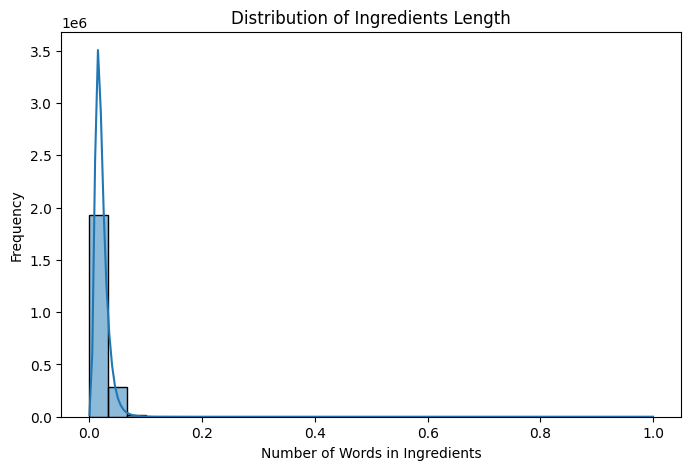

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df["ingredients_length"], bins=30, kde=True)
plt.xlabel("Number of Words in Ingredients")
plt.ylabel("Frequency")
plt.title("Distribution of Ingredients Length")
plt.show()

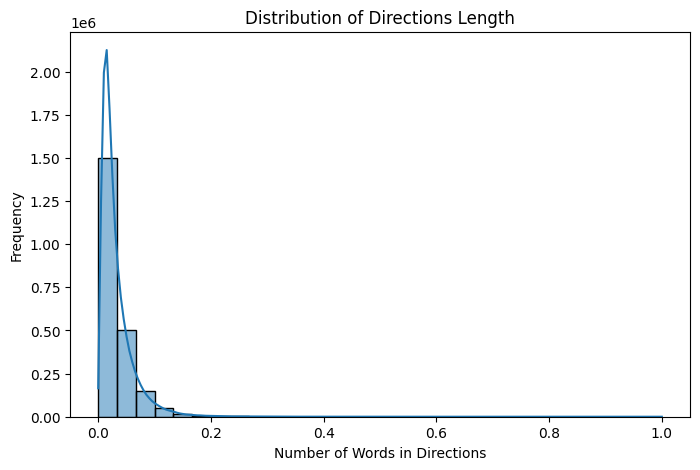

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df["directions_length"], bins=30, kde=True)
plt.xlabel("Number of Words in Directions")
plt.ylabel("Frequency")
plt.title("Distribution of Directions Length")
plt.show()

- Purpose: These histograms visualize the distribution of text lengths for ingredients and directions.
- Why it’s useful:
  - It helps identify outliers, such as extremely short or long recipes.
  - If the distribution is heavily skewed, normalization or transformation techniques might be necessary.
- Key Insight: A normally distributed or slightly skewed pattern is ideal. If there are extreme variations, it may affect model training.

#### **3.2 Bar Chart of Top Recipe Sources**

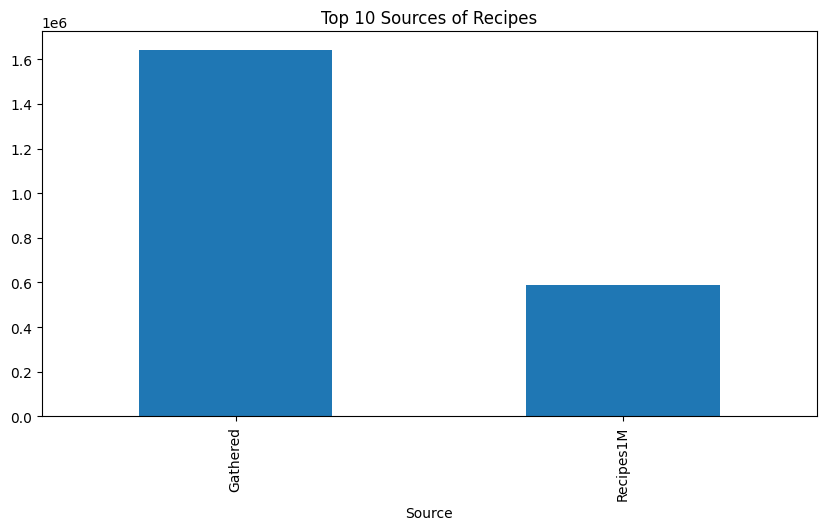

In [14]:
df["source"].value_counts().head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Sources of Recipes")
plt.xlabel("Source")
plt.show()

- Purpose: This bar chart highlights the most frequently occurring recipe sources in the dataset.
- Why it’s useful:
  - If certain sources dominate the dataset, there might be biases that should be accounted for in model training.
  - It helps understand the diversity of the dataset (e.g., does one website contribute disproportionately?).
- Key Insight: If a single source contributes the majority of the data, it might lead to biased model predictions.

#### **3.3 Scatter Plot for Ingredients vs Directions Length**

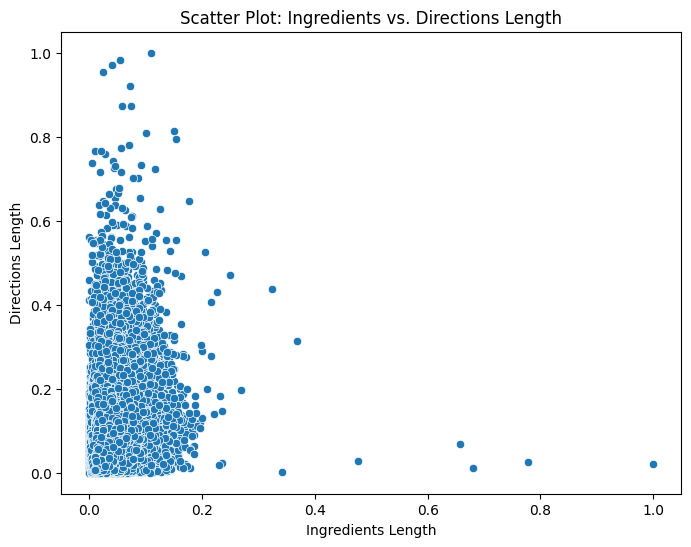

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["ingredients_length"], y=df["directions_length"])
plt.xlabel("Ingredients Length")
plt.ylabel("Directions Length")
plt.title("Scatter Plot: Ingredients vs. Directions Length")
plt.show()

A scatter plot helps visualize the relationship between ingredient and direction lengths.
- Purpose: A scatter plot helps visualize the relationship between the number of words in the ingredients list and the length of the cooking directions.
- Why it’s useful:
  - It helps identify whether recipes with longer ingredient lists also have more detailed directions.
  - If the data follows a pattern, it could indicate a correlation useful for predictive modeling.
- Key Insight: If there is a strong positive correlation, we may infer that recipes with extensive ingredient lists also require more cooking instructions.

#### **3.4 Correlation Heatmap**

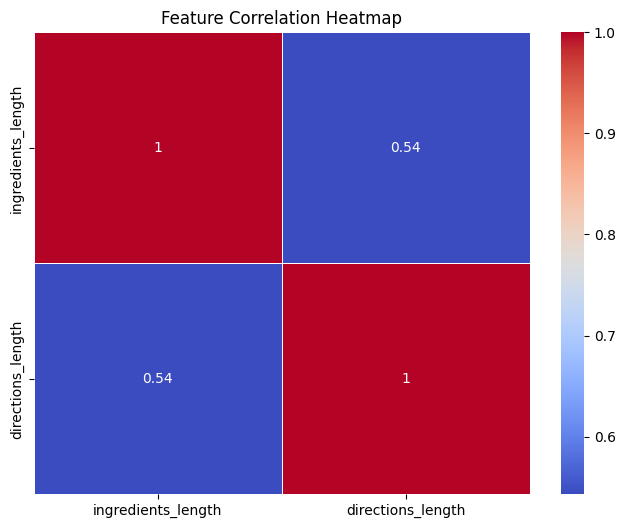

In [16]:
plt.figure(figsize=(8,6))
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

The heatmap identifies feature relationships to improve feature selection.
- Purpose: The heatmap visualizes correlations between different numerical features.
- Why it’s useful:
  - Features with strong correlations (positive or negative) may indicate redundancy.
  - If two features are highly correlated (e.g., ingredients_length and directions_length), we might consider removing one to avoid multicollinearity in machine learning models.
- Key Insight:
  - A correlation closer to +1 or -1 indicates a strong relationship.
  - Features with weak correlations (near 0) do not contribute much to prediction.
  - Strong correlations could mean that some features are redundant.

#### **3.5 Data Imbalance Check**

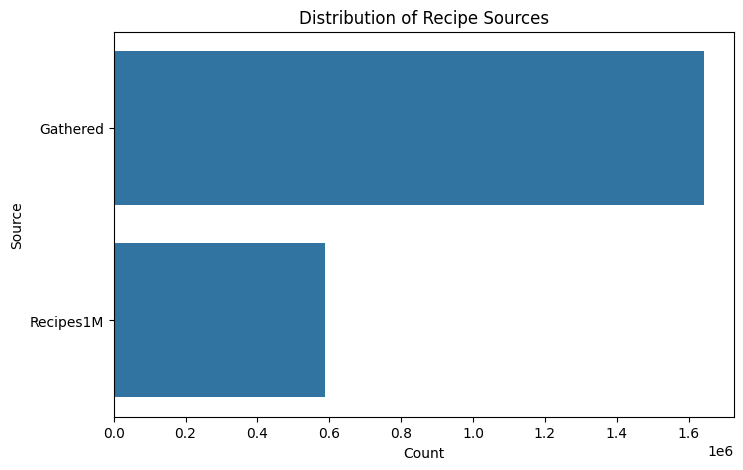

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(y=df["source"], order=df["source"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Source")
plt.title("Distribution of Recipe Sources")
plt.show()

A count plot helps identify class imbalances in categorical variables.

- Purpose: This count plot identifies imbalances in categorical features, particularly recipe sources.
- Why it’s useful:
  - If some sources dominate the dataset, it might introduce a bias in AI predictions.
  - Ensuring balanced representation improves generalizability.
- Key Insight:
  - If a few sources contribute disproportionately, we might consider down-sampling the dominant category or up-sampling underrepresented sources.

### **4. Feature Engineering**
Feature engineering is the process of creating new variables that help the model capture hidden patterns.

#### **4.1 Creating New Features**

In [18]:
df["complexity_score"] = df["ingredients_length"] + df["directions_length"]

# Create additional features
df["avg_word_length"] = df["ingredients"].apply(lambda x: np.mean([len(word) for word in x.split()]))
df["ingredient_count"] = df["ingredients"].apply(lambda x: len(set(x.split(','))))

- Purpose: These new features add more predictive power to the model.
- Why it’s useful:
  - complexity_score: Helps define recipe complexity based on the number of ingredients and steps.
  - avg_word_length: Measures text readability and complexity, potentially distinguishing simple and complex recipes.
  - ingredient_count: Gives a precise count of unique ingredients, which may impact cooking difficulty.
- Key Insight:
  - These features allow AI models to differentiate between simple and complex recipes, improving classification and recommendation accuracy.



### **5. Saving the Processed Dataset**

In [19]:

new_file_path = "/content/drive/My Drive/modified_dataset.csv"
df.to_csv(new_file_path, index=False)  # Save without the index column


The final dataset is saved in csv format for model training.


## Conclusion
Data visualization and feature engineering are crucial steps in any data-driven project, as they provide deep insights into the dataset and help enhance the predictive power of machine learning models. In this analysis, we explored the distribution of key text-based attributes such as ingredient and direction lengths, examined recipe sources, and identified potential correlations between features. These visualizations helped us detect trends, potential biases, and class imbalances, ensuring that our dataset is well-prepared for further analysis.

The histograms of ingredient and direction lengths revealed the variability in recipe complexity, which can influence how a model classifies or recommends recipes. The bar chart of recipe sources highlighted the dominance of certain sources, which may lead to biases in model predictions. The scatter plot between ingredients and directions lengths provided insights into the relationship between the number of ingredients and the length of cooking instructions, helping us understand how detailed recipes tend to be. Additionally, the correlation heatmap allowed us to identify strongly related features, ensuring that redundant variables do not negatively impact model performance.

Beyond visualization, feature engineering played a significant role in refining our dataset. By creating new variables such as complexity_score, avg_word_length, and ingredient_count, we enriched the dataset with meaningful attributes that better capture the essence of each recipe. These engineered features help models differentiate between simple and complex recipes, improving classification accuracy and recommendation quality.